In [10]:
import pandas as pd
df1 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Reporte_25Nov.xlsx")
df2 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Resultados_24Nov.xlsx")
df3 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Reporte_27Nov.xlsx")
print(f"Archivo 1: {len(df1)} registros")
print(f"Archivo 2: {len(df2)} registros")
print(f"Archivo 3: {len(df3)} registros")
print(f"Total: {len(df1) + len(df2) + len(df3)} registros")

# 2. Verificar si hay duplicados
df_total = pd.concat([df1, df2, df3])
print(f"Sin filtrar: {len(df_total)} registros")
print(f"Duplicados: {df_total.duplicated().sum()}")

Archivo 1: 64 registros
Archivo 2: 51 registros
Archivo 3: 54 registros
Total: 169 registros
Sin filtrar: 169 registros
Duplicados: 0


In [11]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 0 to 53
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Customer id       115 non-null    float64       
 1   Quiere baja       115 non-null    object        
 2   Acepto descuento  115 non-null    object        
 3   Fecha respuesta   115 non-null    object        
 4   customer_id       54 non-null     float64       
 5   quiere_baja       54 non-null     object        
 6   acepto_descuento  54 non-null     object        
 7   fecha_respuesta   54 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 11.9+ KB


In [16]:
df_total.head()

,Customer id,Quiere baja,Acepto descuento,Fecha respuesta,customer_id,quiere_baja,acepto_descuento,fecha_respuesta
0,52663366.0,No,No,"Nov. 26, 2025, 8:49 a.m.",NaN,NaN,NaN,NaT
1,55719471.0,No,Si,"Nov. 26, 2025, 8:47 a.m.",NaN,NaN,NaN,NaT
2,55386313.0,No,Si,"Nov. 25, 2025, 8:10 p.m.",NaN,NaN,NaN,NaT
3,55976706.0,Si,Si,"Nov. 25, 2025, 8:02 p.m.",NaN,NaN,NaN,NaT
4,55992681.0,Si,No,"Nov. 25, 2025, 7:49 p.m.",NaN,NaN,NaN,NaT


In [9]:

def homologar_dataframe(df):
    """
    Homologa nombres de columnas y limpia datos de respuestas de clientes.
    """
    # 1. Renombrar columnas a formato estándar (snake_case)
    column_mapping = {
        'Customer id': 'customer_id',
        'Quiere baja': 'quiere_baja',
        'Acepto descuento': 'acepto_descuento',
        'Fecha respuesta': 'fecha_respuesta'
    }
    df = df.rename(columns=column_mapping)
    
    # 2. Si hay columnas duplicadas después del rename, consolidar
    # (tomando el valor no nulo de cada fila)
    if df.columns.duplicated().any():
        df = df.groupby(level=0, axis=1).first()
    
    # 3. Limpiar customer_id
    df['customer_id'] = pd.to_numeric(df['customer_id'], errors='coerce').astype('Int64')
    
    # 4. Normalizar valores Si/No (mayúsculas/minúsculas)
    def normalizar_sino(valor):
        if pd.isna(valor):
            return None
        valor_str = str(valor).strip().upper()
        if valor_str in ['SI', 'SÍ', 'YES', '1', 'TRUE']:
            return 'SI'
        elif valor_str in ['NO', '0', 'FALSE']:
            return 'NO'
        return valor_str
    
    df['quiere_baja'] = df['quiere_baja'].apply(normalizar_sino)
    df['acepto_descuento'] = df['acepto_descuento'].apply(normalizar_sino)
    
    # 5. Parsear fechas con múltiples formatos
    def parsear_fecha(fecha):
        if pd.isna(fecha):
            return None
        if isinstance(fecha, pd.Timestamp):
            return fecha
        
        fecha_str = str(fecha).strip()
        formatos = [
            '%d/%m/%Y %H:%M',           # 26/11/2025 09:04
            '%Y-%m-%d %H:%M:%S',        # 2025-11-26 09:04:00
            '%b. %d, %Y, %I:%M %p',     # Nov. 26, 2025, 8:49 a.m.
        ]
        
        for fmt in formatos:
            try:
                return pd.to_datetime(fecha_str, format=fmt)
            except:
                continue
        
        # Manejo especial para formato "Nov. 26, 2025, 8:49 a.m."
        try:
            fecha_limpia = fecha_str.replace('a.m.', 'AM').replace('p.m.', 'PM')
            fecha_limpia = fecha_limpia.replace('.', '')
            return pd.to_datetime(fecha_limpia, format='%b %d, %Y, %I:%M %p')
        except:
            pass
        
        # Último intento con inferencia automática
        try:
            return pd.to_datetime(fecha_str, dayfirst=True)
        except:
            return None
    
    df['fecha_respuesta'] = df['fecha_respuesta'].apply(parsear_fecha)
    
    # 6. Eliminar filas completamente vacías
    df = df.dropna(how='all')
    
    # 7. Ordenar columnas
    columnas_ordenadas = ['customer_id', 'quiere_baja', 'acepto_descuento', 'fecha_respuesta']
    df = df[[col for col in columnas_ordenadas if col in df.columns]]
    
    return df


# Uso:
df_limpio = homologar_dataframe(df_total)

# Si tienes múltiples dataframes y quieres combinarlos:
def combinar_dataframes(lista_dfs):
    """Homologa y combina una lista de dataframes."""
    dfs_limpios = [homologar_dataframe(df) for df in lista_dfs]
    df_final = pd.concat(dfs_limpios, ignore_index=True)
    
    # Eliminar duplicados por customer_id (quedarse con el más reciente)
    df_final = df_final.sort_values('fecha_respuesta', ascending=False)
    df_final = df_final.drop_duplicates(subset='customer_id', keep='first')
    df_final = df_final.sort_values('fecha_respuesta', ascending=False).reset_index(drop=True)
    
    return df_final

# Uso:
df_final = combinar_dataframes([df1, df2, df3])

NameError: name 'df_total' is not defined

In [19]:
df_final

,customer_id,quiere_baja,acepto_descuento,fecha_respuesta
0,54795425,NO,SI,2025-11-27 07:02:00
1,54612526,NO,SI,2025-11-26 21:04:00
2,55698374,NO,SI,2025-11-26 18:54:00
3,54537838,NO,SI,2025-11-26 18:46:00
4,55886303,SI,NO,2025-11-26 18:12:00
...,...,...,...,...
159,56040153,SI,NO,NaT
160,55557651,NO,NO,NaT
161,54905613,NO,NO,NaT
162,55185381,SI,NO,NaT


In [12]:
df_final.to_excel(r"C:\Users\resendizjg\Downloads\Reporte_Homologado_27Noviembre2025.xlsx", index=False)

DEMO: Pipeline con fecha de archivo y columna origen

----------------------------------------------------------------------
PASO 1: Homologando DataFrames individuales
----------------------------------------------------------------------
  → Fecha de corte asignada: 2025-11-24
  → 22 registros sin fecha_respuesta, asignada fecha del archivo
  → Fecha de corte asignada: 2025-11-25
  → Fecha de corte asignada: 2025-11-26

----------------------------------------------------------------------
PASO 2: Combinando DataFrames
----------------------------------------------------------------------

----------------------------------------------------------------------
Resumen por archivo origen:
----------------------------------------------------------------------
                  registros  aceptaron
origen                                
respuestas_24Nov         47         28
respuestas_25Nov         63         47
respuestas_26Nov         54         40

-----------------------------------

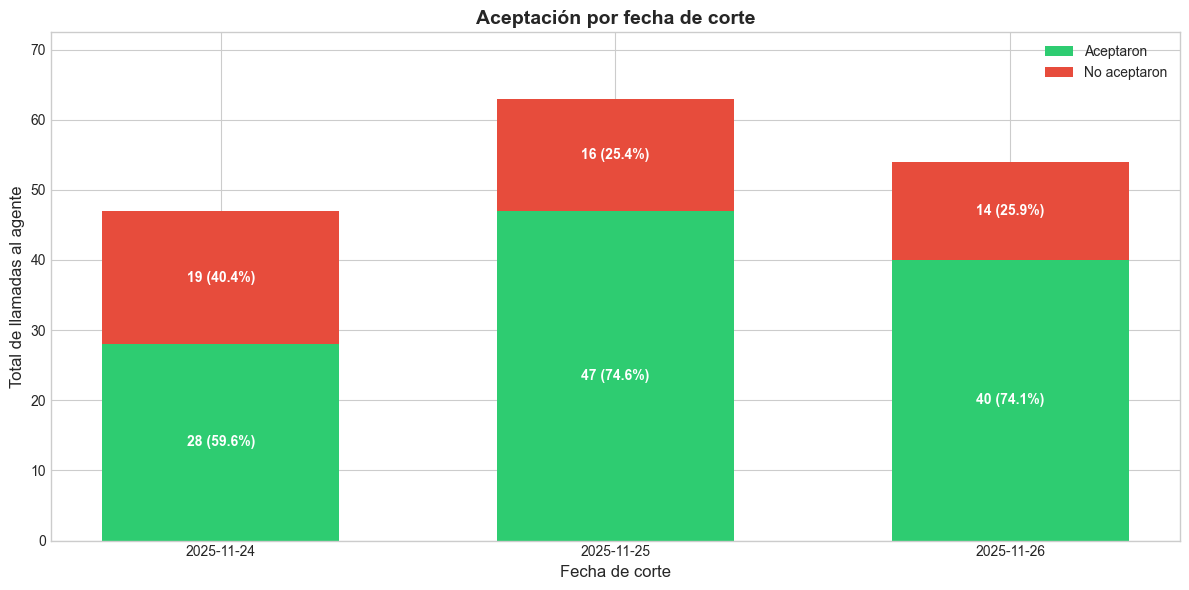

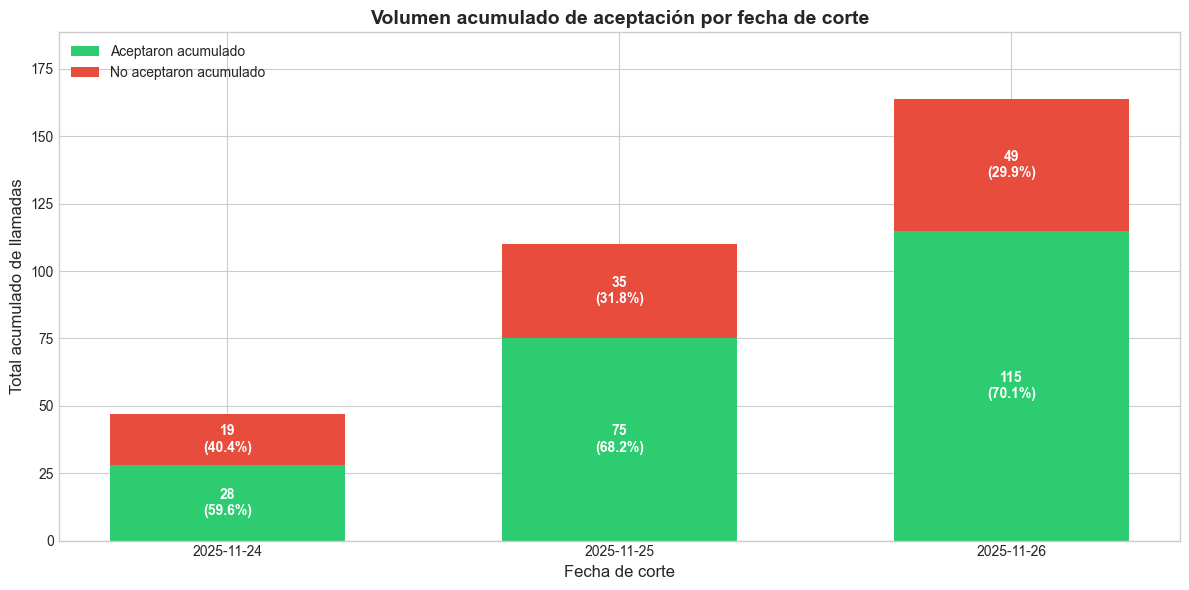

In [ ]:
"""
Pipeline completo: Homologar DataFrames y generar gráficas de aceptación.
- Extrae fecha del nombre del archivo para registros sin fecha
- Agrega columna de origen del archivo
Autor: Memo - HITSS
Fecha: Noviembre 2025
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from datetime import datetime
from typing import List, Tuple, Optional, Union
from pathlib import Path


# ============================================================
# PARTE 1: EXTRACCIÓN DE FECHA DEL NOMBRE DE ARCHIVO
# ============================================================

def extraer_fecha_de_nombre(nombre_archivo: str) -> Optional[pd.Timestamp]:
    """
    Extrae la fecha del nombre del archivo.
    Formato esperado: *_27Nov.xlsx, *_03Dic.xlsx, etc.
    
    Parámetros:
    -----------
    nombre_archivo : str
        Nombre del archivo (ej: 'respuestas_27Nov.xlsx')
    
    Retorna:
    --------
    pd.Timestamp o None
    """
    # Mapeo de meses en español a número
    meses = {
        'ene': 1, 'enero': 1,
        'feb': 2, 'febrero': 2,
        'mar': 3, 'marzo': 3,
        'abr': 4, 'abril': 4,
        'may': 5, 'mayo': 5,
        'jun': 6, 'junio': 6,
        'jul': 7, 'julio': 7,
        'ago': 8, 'agosto': 8,
        'sep': 9, 'sept': 9, 'septiembre': 9,
        'oct': 10, 'octubre': 10,
        'nov': 11, 'noviembre': 11,
        'dic': 12, 'diciembre': 12,
    }
    
    # Patrón para extraer día y mes: _27Nov, _03Dic, _1Ene, etc.
    patron = r'_(\d{1,2})([A-Za-z]+)\.xlsx'
    match = re.search(patron, nombre_archivo, re.IGNORECASE)
    
    if match:
        dia = int(match.group(1))
        mes_str = match.group(2).lower()
        
        # Buscar el mes
        mes = meses.get(mes_str)
        if mes:
            # Asumir año actual o 2025
            año = datetime.now().year
            try:
                fecha = pd.Timestamp(year=año, month=mes, day=dia, hour=12, minute=0)
                return fecha
            except:
                return None
    
    return None


def obtener_nombre_base(ruta_archivo: str) -> str:
    """
    Obtiene el nombre base del archivo sin extensión.
    
    Parámetros:
    -----------
    ruta_archivo : str
        Ruta completa o nombre del archivo
    
    Retorna:
    --------
    str
        Nombre base del archivo
    """
    return Path(ruta_archivo).stem


# ============================================================
# PARTE 2: HOMOLOGACIÓN DE DATAFRAMES
# ============================================================

def homologar_dataframe(df: pd.DataFrame, 
                        nombre_archivo: Optional[str] = None) -> pd.DataFrame:
    """
    Homologa nombres de columnas y limpia datos de respuestas de clientes.
    
    Parámetros:
    -----------
    df : pd.DataFrame
        DataFrame con columnas de respuestas de clientes
    nombre_archivo : str, opcional
        Nombre del archivo origen para:
        - Agregar columna 'origen'
        - Extraer fecha para registros sin fecha
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame limpio con columnas estandarizadas
    """
    df = df.copy()
    
    # Renombrar columnas a formato estándar
    column_mapping = {
        'Customer id': 'customer_id',
        'Customer Id': 'customer_id',
        'CUSTOMER_ID': 'customer_id',
        'Quiere baja': 'quiere_baja',
        'Quiere Baja': 'quiere_baja',
        'QUIERE_BAJA': 'quiere_baja',
        'Acepto descuento': 'acepto_descuento',
        'Acepto Descuento': 'acepto_descuento',
        'ACEPTO_DESCUENTO': 'acepto_descuento',
        'Fecha respuesta': 'fecha_respuesta',
        'Fecha Respuesta': 'fecha_respuesta',
        'FECHA_RESPUESTA': 'fecha_respuesta',
    }
    df = df.rename(columns=column_mapping)
    
    # Consolidar columnas duplicadas
    if df.columns.duplicated().any():
        df = df.groupby(level=0, axis=1).first()
    
    # Limpiar customer_id
    df['customer_id'] = pd.to_numeric(df['customer_id'], errors='coerce').astype('Int64')
    
    # Normalizar valores Si/No
    df['quiere_baja'] = df['quiere_baja'].apply(_normalizar_sino)
    df['acepto_descuento'] = df['acepto_descuento'].apply(_normalizar_sino)
    
    # Parsear fechas existentes
    df['fecha_respuesta'] = df['fecha_respuesta'].apply(_parsear_fecha)
    
    # === Agregar columna de origen y fecha de corte ===
    if nombre_archivo:
        df['origen'] = obtener_nombre_base(nombre_archivo)
        
        # La fecha del archivo define el día de corte para TODOS los registros
        fecha_archivo = extraer_fecha_de_nombre(nombre_archivo)
        if fecha_archivo:
            df['fecha_corte'] = fecha_archivo.normalize()  # Solo la fecha, sin hora
            print(f"  → Fecha de corte asignada: {fecha_archivo.strftime('%Y-%m-%d')}")
            
            # Si hay registros sin fecha_respuesta, asignar la fecha del archivo
            mask_sin_fecha = df['fecha_respuesta'].isna()
            n_sin_fecha = mask_sin_fecha.sum()
            if n_sin_fecha > 0:
                df.loc[mask_sin_fecha, 'fecha_respuesta'] = fecha_archivo
                print(f"  → {n_sin_fecha} registros sin fecha_respuesta, asignada fecha del archivo")
        else:
            df['fecha_corte'] = pd.NaT
    else:
        df['origen'] = 'desconocido'
        df['fecha_corte'] = pd.NaT
    
    # Eliminar filas vacías
    df = df.dropna(how='all')
    
    # Ordenar columnas
    columnas_ordenadas = ['customer_id', 'quiere_baja', 'acepto_descuento', 'fecha_respuesta', 'fecha_corte', 'origen']
    df = df[[col for col in columnas_ordenadas if col in df.columns]]
    
    return df


def _normalizar_sino(valor) -> Optional[str]:
    """Normaliza valores SI/NO."""
    if pd.isna(valor):
        return None
    valor_str = str(valor).strip().upper()
    if valor_str in ['SI', 'SÍ', 'YES', '1', 'TRUE', 'S','si']:
        return 'SI'
    elif valor_str in ['NO', '0', 'FALSE', 'N', 'no']:
        return 'NO'
    return valor_str


def _parsear_fecha(fecha) -> Optional[pd.Timestamp]:
    """Parsea fechas en múltiples formatos."""
    if pd.isna(fecha):
        return None
    if isinstance(fecha, pd.Timestamp):
        return fecha
    
    fecha_str = str(fecha).strip()
    
    # Si está vacío o es solo espacios
    if not fecha_str or fecha_str.lower() in ['nan', 'nat', 'none', '']:
        return None
    
    formatos = [
        '%d/%m/%Y %H:%M',
        '%d/%m/%Y %H:%M:%S',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%d-%m-%Y %H:%M:%S',
        '%d-%m-%Y %H:%M',
        '%d/%m/%Y',
        '%Y-%m-%d',
    ]
    
    for fmt in formatos:
        try:
            return pd.to_datetime(fecha_str, format=fmt)
        except:
            continue
    
    # Formato "Nov. 26, 2025, 8:49 a.m."
    try:
        fecha_limpia = fecha_str.replace('a.m.', 'AM').replace('p.m.', 'PM').replace('.', '')
        return pd.to_datetime(fecha_limpia, format='%b %d, %Y, %I:%M %p')
    except:
        pass
    
    try:
        return pd.to_datetime(fecha_str, dayfirst=True)
    except:
        return None


def cargar_y_homologar_excel(ruta_archivo: str) -> pd.DataFrame:
    """
    Carga un archivo Excel y lo homologa automáticamente.
    
    Parámetros:
    -----------
    ruta_archivo : str
        Ruta al archivo Excel
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame homologado con columna de origen
    """
    nombre = os.path.basename(ruta_archivo)
    print(f"\nCargando: {nombre}")
    
    df = pd.read_excel(ruta_archivo)
    print(f"  → {len(df)} registros encontrados")
    
    df_homologado = homologar_dataframe(df, nombre_archivo=nombre)
    print(f"  → {len(df_homologado)} registros después de limpieza")
    
    return df_homologado


def combinar_dataframes(lista_dfs: List[pd.DataFrame], 
                        eliminar_duplicados: bool = True) -> pd.DataFrame:
    """Combina una lista de DataFrames ya homologados."""
    df_final = pd.concat(lista_dfs, ignore_index=True)
    
    if eliminar_duplicados:
        df_final = df_final.sort_values('fecha_respuesta', ascending=False)
        df_final = df_final.drop_duplicates(subset='customer_id', keep='first')
        df_final = df_final.reset_index(drop=True)
    
    return df_final


def cargar_multiples_archivos(lista_rutas: List[str], 
                               eliminar_duplicados: bool = True) -> pd.DataFrame:
    """
    Carga y combina múltiples archivos Excel.
    
    Parámetros:
    -----------
    lista_rutas : List[str]
        Lista de rutas a archivos Excel
    eliminar_duplicados : bool
        Si True, elimina duplicados por customer_id
    
    Retorna:
    --------
    pd.DataFrame
        DataFrame combinado y homologado
    """
    dfs = []
    for ruta in lista_rutas:
        try:
            df = cargar_y_homologar_excel(ruta)
            dfs.append(df)
        except Exception as e:
            print(f"Error cargando {ruta}: {e}")
    
    if not dfs:
        return pd.DataFrame()
    
    return combinar_dataframes(dfs, eliminar_duplicados=eliminar_duplicados)


# ============================================================
# PARTE 3: GENERACIÓN DE GRÁFICAS
# ============================================================

def crear_graficas_aceptacion(df: pd.DataFrame, 
                               guardar: bool = True,
                               ruta_salida: str = './') -> Tuple[plt.Figure, plt.Figure, pd.DataFrame]:
    """
    Crea gráficas de barras apiladas para aceptación de descuentos.
    Agrupa por fecha_corte (fecha del archivo), no por fecha_respuesta.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    
    df = df.copy()
    
    # Usar fecha_corte (del nombre del archivo) para agrupar
    if 'fecha_corte' not in df.columns:
        # Si no existe, crearla desde fecha_respuesta
        df['fecha_respuesta'] = pd.to_datetime(df['fecha_respuesta'])
        df['fecha_corte'] = df['fecha_respuesta'].dt.normalize()
    
    df['acepto'] = df['acepto_descuento'].str.upper().isin(['SI', 'SÍ', 'YES', '1'])
    
    # Agrupar por fecha de corte (día del archivo)
    resumen = df.groupby('fecha_corte').agg(
        total=('customer_id', 'count'),
        aceptaron=('acepto', 'sum')
    ).reset_index()
    
    resumen['no_aceptaron'] = resumen['total'] - resumen['aceptaron']
    resumen['pct_aceptaron'] = (resumen['aceptaron'] / resumen['total'] * 100).round(1)
    resumen['pct_no_aceptaron'] = (resumen['no_aceptaron'] / resumen['total'] * 100).round(1)
    resumen = resumen.sort_values('fecha_corte')
    
    # Calcular acumulados
    resumen['aceptaron_acum'] = resumen['aceptaron'].cumsum()
    resumen['no_aceptaron_acum'] = resumen['no_aceptaron'].cumsum()
    resumen['total_acum'] = resumen['total'].cumsum()
    resumen['pct_aceptaron_acum'] = (resumen['aceptaron_acum'] / resumen['total_acum'] * 100).round(1)
    resumen['pct_no_aceptaron_acum'] = (resumen['no_aceptaron_acum'] / resumen['total_acum'] * 100).round(1)
    
    # Colores
    COLOR_ACEPTARON = '#2ecc71'
    COLOR_NO_ACEPTARON = '#e74c3c'
    
    x = np.arange(len(resumen))
    width = 0.6
    
    # ============ GRÁFICA 1: Por día ============
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.bar(x, resumen['aceptaron'], width, label='Aceptaron', color=COLOR_ACEPTARON)
    ax1.bar(x, resumen['no_aceptaron'], width, bottom=resumen['aceptaron'],
            label='No aceptaron', color=COLOR_NO_ACEPTARON)
    
    for i, row in resumen.iterrows():
        idx = list(resumen.index).index(i)
        if row['aceptaron'] > 0:
            ax1.text(idx, row['aceptaron']/2, f"{int(row['aceptaron'])} ({row['pct_aceptaron']}%)",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        if row['no_aceptaron'] > 0:
            ax1.text(idx, row['aceptaron'] + row['no_aceptaron']/2, 
                    f"{int(row['no_aceptaron'])} ({row['pct_no_aceptaron']}%)",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
    
    ax1.set_xlabel('Fecha de corte', fontsize=12)
    ax1.set_ylabel('Total de llamadas al agente', fontsize=12)
    ax1.set_title('Aceptación por fecha de corte', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(resumen['fecha_corte'].dt.strftime('%Y-%m-%d'))
    ax1.legend(loc='upper right')
    ax1.set_ylim(0, resumen['total'].max() * 1.15)
    plt.tight_layout()
    
    # ============ GRÁFICA 2: Acumulada ============
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    
    ax2.bar(x, resumen['aceptaron_acum'], width, label='Aceptaron acumulado', color=COLOR_ACEPTARON)
    ax2.bar(x, resumen['no_aceptaron_acum'], width, bottom=resumen['aceptaron_acum'],
            label='No aceptaron acumulado', color=COLOR_NO_ACEPTARON)
    
    for i, row in resumen.iterrows():
        idx = list(resumen.index).index(i)
        if row['aceptaron_acum'] > 0:
            ax2.text(idx, row['aceptaron_acum']/2, 
                    f"{int(row['aceptaron_acum'])}\n({row['pct_aceptaron_acum']}%)",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
        if row['no_aceptaron_acum'] > 0:
            ax2.text(idx, row['aceptaron_acum'] + row['no_aceptaron_acum']/2,
                    f"{int(row['no_aceptaron_acum'])}\n({row['pct_no_aceptaron_acum']}%)",
                    ha='center', va='center', color='white', fontweight='bold', fontsize=10)
    
    ax2.set_xlabel('Fecha de corte', fontsize=12)
    ax2.set_ylabel('Total acumulado de llamadas', fontsize=12)
    ax2.set_title('Volumen acumulado de aceptación por fecha de corte', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(resumen['fecha_corte'].dt.strftime('%Y-%m-%d'))
    ax2.legend(loc='upper left')
    ax2.set_ylim(0, resumen['total_acum'].max() * 1.15)
    plt.tight_layout()
    
    if guardar:
        fig1.savefig(f'{ruta_salida}/grafica_aceptacion_diaria.png', dpi=150, bbox_inches='tight')
        fig2.savefig(f'{ruta_salida}/grafica_aceptacion_acumulada.png', dpi=150, bbox_inches='tight')
        print(f"Gráficas guardadas en: {ruta_salida}")
    
    return fig1, fig2, resumen


# ============================================================
# EJEMPLO DE USO COMPLETO
# ============================================================

if __name__ == "__main__":
    
    print("=" * 70)
    print("DEMO: Pipeline con fecha de archivo y columna origen")
    print("=" * 70)
    
    # Simular DataFrames como si vinieran de archivos
    # Archivo 1: respuestas_24Nov.xlsx (algunos sin fecha)
    df1 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Reporte_24Nov.xlsx")
    df2 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Reporte_25Nov.xlsx")
    df3 = pd.read_excel(r"C:\Users\resendizjg\Downloads\piloto_resultados\Reporte_26Nov.xlsx")
    
    # Homologar cada DataFrame con su nombre de archivo
    print("\n" + "-" * 70)
    print("PASO 1: Homologando DataFrames individuales")
    print("-" * 70)
    
    df1_h = homologar_dataframe(df1, nombre_archivo='respuestas_24Nov.xlsx')
    df2_h = homologar_dataframe(df2, nombre_archivo='respuestas_25Nov.xlsx')
    df3_h = homologar_dataframe(df3, nombre_archivo='respuestas_26Nov.xlsx')

    
    # Combinar todos
    print("\n" + "-" * 70)
    print("PASO 2: Combinando DataFrames")
    print("-" * 70)
    
    df_final = combinar_dataframes([df1_h, df2_h, df3_h,])
    
    
    # Resumen por origen
    print("\n" + "-" * 70)
    print("Resumen por archivo origen:")
    print("-" * 70)
    print(df_final.groupby('origen').agg(
        registros=('customer_id', 'count'),
        aceptaron=('acepto_descuento', lambda x: (x == 'SI').sum())
    ))
    
    # Generar gráficas
    print("\n" + "-" * 70)
    print("PASO 3: Generando gráficas")
    print("-" * 70)
    
    fig1, fig2, resumen = crear_graficas_aceptacion(df_final, guardar=True, ruta_salida='.')
    
    print("\nResumen por fecha:")
    print(resumen[['fecha_corte', 'aceptaron', 'no_aceptaron', 'total', 'pct_aceptaron']].to_string(index=False))

In [20]:
df_final.groupby('origen').agg(
        registros=('customer_id', 'count'),
        aceptaron=('acepto_descuento', lambda x: (x == 'SI').sum()))

,registros,aceptaron
origen,,
respuestas_24Nov,47,28
respuestas_25Nov,63,47
respuestas_26Nov,54,40


In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Customer id       51 non-null     int64 
 1   Quiere baja       51 non-null     object
 2   Acepto descuento  51 non-null     object
 3   Fecha respuesta   51 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.7+ KB
